# STOCK PRICE PREDICTIONS

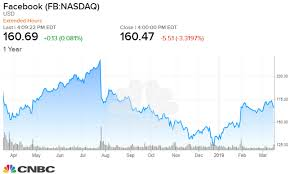


<br>
I have been working in a Company where i have to give stcok price predictions for the upcoming year for differnent commodities,so i decied to make my own Notebook in it.
<hr>

## What is stock price predictions?

Stock market prediction is the act of trying to determine the future value of a company stock or other financial instrument traded on an exchange. The successful prediction of a stock's future price could yield significant profit.

# Loading and importing Data

In [ ]:
import numpy as np
import pandas as pd
data=pd.read_csv("../input/stock-price-predictions/Apple.csv",index_col="Price Date",parse_dates=["Price Date"])

In [ ]:
data.head()

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
data["Modal Price (Rs./Quintal)"]["2019":].plot(figsize=(16,9),legend=True,color='r')
data["Modal Price (Rs./Quintal)"][:"2019"].plot(figsize=(16,9),legend=True,color='g')
plt.legend(['Training set (Before 2019)','Test set (2019 and beyond)'])
plt.title('Apple stock price')
plt.show()

# Splitting and scaling of Data
For stock price predictions,we have to split the data according to which year or month or day,for the time period we want to predict

In [ ]:
training_set = data['2019':].iloc[:,2:3].values
test_set = data[:'2019'].iloc[:,2:3].values

In [ ]:
training_set

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
test_scaled=sc.fit_transform(test_set)

In [ ]:
training_set_scaled.shape,test_scaled.shape

In [ ]:
X_train = []
y_train = []
for i in range(60,4732):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
test_scaled.shape

In [ ]:
X_test = []
y_test = []
for i in range(60,159):
    X_test.append(test_scaled[i-60:i,0])
    y_test.append(test_scaled[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_train.shape,X_test.shape

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from sklearn.metrics import mean_squared_error

In [ ]:
regressorGRU = Sequential()
regressorGRU.add(Bidirectional(GRU(50, return_sequences=True, input_shape=(X_train.shape[1],1))))
regressorGRU.add(Bidirectional(GRU(50, return_sequences=True)))
regressorGRU.add(Bidirectional(GRU(50, return_sequences=True)))
regressorGRU.add(Bidirectional(GRU(50)))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1))
regressorGRU.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['accuracy'])
regressorGRU.fit(X_train,y_train,epochs=5,batch_size=32,validation_data=(X_test,y_test))

In [ ]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(test_set, color='red',label='Real Apple Stock Price')
plt.plot(GRU_predicted_stock_price, color='blue',label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction(GRU)')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [ ]:
test_set=test_set[:99,]
test_set.shape,GRU_predicted_stock_price.shape

In [ ]:
rmse = math.sqrt(mean_squared_error(test_set, GRU_predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

# Sarimax

In [ ]:
import numpy as np
import pandas as pd
data=pd.read_csv("../input/stock-price-predictions/Apple.csv",parse_dates=["Price Date"])

In [ ]:
data.head()

In [ ]:
rpass=data
from statsmodels.tsa.stattools import adfuller
def adfuller_test(passenger):
    res=adfuller(passenger)
    labels=["ADF TEST STATISTICS","P-VALUE","LAGS USED","NUMBER OF OBSERVATION USED"]
    for value,label in zip(res,labels):
        print(label+' : '+str(value))
    if(res[1]<=0.05):
        print("Stationary")
    else:
        print("Not Stationary")
adfuller_test(rpass.reset_index()["Modal Price (Rs./Quintal)"])

In [ ]:
rpass["seasonal difference"]=rpass["Modal Price (Rs./Quintal)"]-rpass["Modal Price (Rs./Quintal)"].shift(30)
rpass.head()

In [ ]:
import plotly.express as px
import seaborn as sns
plt.figure(figsize=(20,5))
adfuller_test(rpass["seasonal difference"].dropna())
px.line(rpass,y="seasonal difference",x="Price Date",title="TREND AFTER SHIFTING")

In [ ]:
data.shape
data=data.set_index("Price Date")
trainset=data.loc["2019":]
testset=data.loc[:"2019"]
testset

In [ ]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(trainset["Modal Price (Rs./Quintal)"],order=(3,0,3),seasonal_order=(2,1,3,30))
results=model.fit()

In [ ]:
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=plot_acf(rpass["seasonal difference"].dropna(),lags=50,ax=ax1)
ax2=fig.add_subplot(212)
fig=plot_pacf(rpass["seasonal difference"].dropna(),lags=50,ax=ax2)

In [ ]:
import matplotlib.pyplot as plt
data["Future Prediction"]=results.predict(start=1,end=5661,dynamic=True)
data[["Modal Price (Rs./Quintal)","Future Prediction"]].plot(figsize=(20,8),color=['r','g'])
plt.title("TESTING PREDICTED VALUE WITH DATASET")


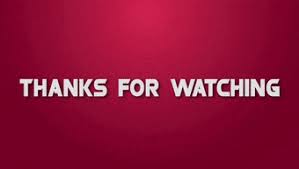
